In [75]:
import local_pcangsd as lp
import lostruct
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt

In [76]:
input = "data/mytilus_test.beagle.gz" # input genotype likelihood file
store = "data/mytilus_test.zarr" # where to store the transformed file

Now we produce an on-disk format of the genotype likelihoods.

`local_pcangsd` functions work with an `xarray.Dataset` to avoid loading all genotype likelihoods into memory.

The Dataset in stored as a zarr file.

Run the following only once.

In [3]:
lp.beagle_to_zarr(input, store, chunksize=10000)

In [77]:
ds = lp.load_dataset(store) # open the Dataset
ds

<xarray.Dataset>
Dimensions:              (variants: 200000, alleles: 2, samples: 218, genotypes: 3)
Dimensions without coordinates: variants, alleles, samples, genotypes
Data variables:
    allele               (variants, alleles) int8 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(10000, 218, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(218,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  ['CM029595.1_RagTag_pilon', 'CM029599.1_RagTag_pilon']

You can see that the dataset is similar to the sgkit internal format.

We now create windows variables, using sgkit functions internally.

In [79]:
ds = lp.window(ds, type='variant', size=1000)
ds

<xarray.Dataset>
Dimensions:              (windows: 200, variants: 200000, alleles: 2, samples: 218, genotypes: 3)
Dimensions without coordinates: windows, variants, alleles, samples, genotypes
Data variables:
    window_contig        (windows) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    window_start         (windows) int64 0 1000 2000 ... 197000 198000 199000
    window_stop          (windows) int64 1000 2000 3000 ... 198000 199000 200000
    allele               (variants, alleles) int8 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(10000, 218, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(218,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  ['CM029595.1_RagTag_pilon', 'CM029599.1_RagTag_pilon']

We compute PCAngsd on each window.

In [80]:
results = lp.pca_windows(ds)

In [81]:
print(f"Results on {results.shape[0]} windows")

Results on 200 windows


The output is formatted to be readable by `lostruct` functions.

In [82]:
pc_dists = lostruct.get_pc_dists(results)

In [83]:
mds = pcoa(pc_dists)

Text(0, 0.5, 'MDS 1')

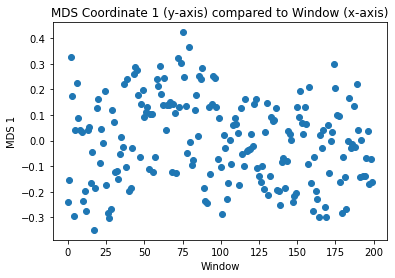

In [84]:
plt.figure()
plt.scatter(x=range(pc_dists.shape[0]), y=mds.samples["PC1"])
plt.title("MDS Coordinate 1 (y-axis) compared to Window (x-axis)")
plt.xlabel("Window")
plt.ylabel("MDS 1")

Text(0, 0.5, 'MDS 2')

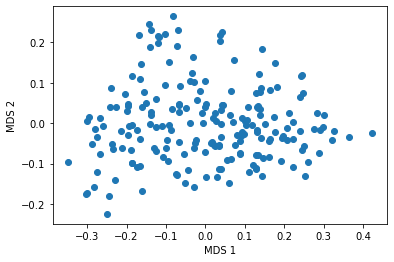

In [85]:
plt.figure()
plt.scatter(x=mds.samples["PC1"], y=mds.samples["PC2"])
plt.xlabel("MDS 1")
plt.ylabel("MDS 2")